# Introduction to Object Detection using Deep Learning - Implementation
---
This notebook is based on the excellent material provided by [Sagar Vinodababu](https://www.linkedin.com/in/svinodababu/) on [GitHub](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection). The theoretical part explaining the concepts is availabe in a [separate notebook](07a_Intro_OD_Theory.ipynb). Here, based on the Python scripts available in the aforementioned GitHub repository, we provide the code implementing those concepts in PyTorch in a basic fashion. In the mini project, you will have to expand this implementation to more closely tie in with the way we implemented and evaluated models before.

More to the point, it should be **noted** that the  [original tutorial](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection) first of all tries to implement the SSD method proposed in the [paper](https://arxiv.org/abs/1512.02325) it is based on and thus uses some of the terminology and approaches specified therein. Also, providing individual scripts to be carried out sequentially will necessitate code to be somewhat different to the way one would do it in an interactive notebook such as this one. Therefore, the **aim** of this notebook is to provide a working first version of the complete process of *training*, *evaluation* and *inference* to demonstrate the ideas explained in the [theoretical part](07a_Intro_OD_Theory.ipynb). It will then be your task in the mini project to make further adjustments more suited to the interactive options of a notebook.

---

## Overview
- [Dataset](#Dataset)
  - [Description](#Description)
  - [Inputs to model](#Inputs-to-model)
    - [Images](#Images)
    - [Objects' Bounding Boxes](#Objects'-Bounding-Boxes)
    - [Objects' Labels](#Objects'-Labels)
  - [Data pipeline](#Data-pipeline)
    - [PyTorch Dataset](#PyTorch-Dataset)
    - [Data Transforms](#Data-Transforms)
    - [PyTorch DataLoader](#PyTorch-DataLoader)
  - [Base Convolutions](#Base-Convolutions)
  - [Auxiliary Convolutions](#Auxiliary-Convolutions)
  - [Prediction Convolutions](#Prediction-Convolutions)
  - [Putting it all together](#Putting-it-all-together)
  - [Multibox Loss](#Multibox-Loss)
  - [Remarks](#Remarks)
  - [Some more examples](#Some-more-examples)
- [Learning Outcomes](#Learning-Outcomes)

---

In [1]:
import json
import os
import random
import time
from PIL import Image, ImageDraw, ImageFont
import xml.etree.ElementTree as ET
from math import sqrt
from itertools import product as product
from tqdm import tqdm
from pprint import PrettyPrinter

import torch
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as FT
from torch.utils.data import Dataset

# make sure the pretrained model is saved to models directory
os.environ['TORCH_HOME'] = 'models'

# the utils we will use (see utils.py - with minor modifications of the GitHub version)
from utils import *


import warnings
warnings.filterwarnings('ignore')
# if you think that you might benefit from seeing warnings at least once do this instead:
#warnings.filterwarnings(action='once')

As always, if possible use a GPU:

In [2]:
USE_ONLY_CPU = False
if USE_ONLY_CPU:
    device = torch.device("cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')

Using cuda


## Dataset

We will use Pascal Visual Object Classes (VOC) data from the years 2007 and 2012. They have been merged together for the training data and we use the images from 2007 for testing. The original data can be downloaded from [here](http://host.robots.ox.ac.uk/pascal/VOC/). We are only interested in the images themselves together with their annotations, so we discarded the other subfolders. Furthermore, we will be using relative paths to the *images* and *annotations* in the JSON-files to be found in the data folder `data\VOC`.

The data provides annotations for 20 different classes which can be read from the tuple below. Also, there we can find a list of distinct colors to differentiate the classes with when displaying the detections on an image.

In [3]:
# Label map
voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 
              'car', 'cat', 'chair', 'cow', 'diningtable',
              'dog', 'horse', 'motorbike', 'person', 'pottedplant', 
              'sheep', 'sofa', 'train', 'tvmonitor')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping

# Color map for bounding boxes of detected objects from 
# https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
distinct_colors = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', 
                   '#f58231', '#911eb4', '#46f0f0', '#f032e6',
                   '#d2f53c', '#fabebe', '#008080', '#000080', 
                   '#aa6e28', '#fffac8', '#800000', '#aaffc3', 
                   '#808000', '#ffd8b1', '#e6beff', '#808080', '#FFFFFF']
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

### Description

The training data is located in the subfolder `train`, the test data in the subfolder `test` of the data folder.

Each image (contained in a subfolder called `JPEGImages`) can contain one or more ground truth objects.

Each object is represented by –

- a bounding box in absolute boundary coordinates

- a label (one of the object types (aka *classes*) mentioned above)

-  a perceived detection difficulty (either `0`, meaning _not difficult_, or `1`, meaning _difficult_)

This meta information is provided in an XML-file (contained in a subfolder called `Annotations`), where the image `xyz.jpg` corresponds to the annotations `xyz.xml`. The meta information for the respective *split*, i.e. `TRAIN` for the training data and `TEST` for the test data has been extracted to the file `{split}_objects.json` and the relative paths to the corresponding images are stored in `{split}_images.json`. Also, the `label_map` given above is available as a JSON-file.

### Inputs to model

We will need three inputs.

#### Images

Since we are using the SSD300 variant, the images have to be sized at `300, 300` pixels and in the RGB format.

Remember, we are using a VGG-16 base pretrained on ImageNet that is already available in PyTorch's `torchvision` module. [This page](https://pytorch.org/docs/master/torchvision/models.html) details the preprocessing or transformation we would need to perform in order to use this model – pixel values must be in the range [0,1] and we must then normalize the image by the mean and standard deviation of the ImageNet images' RGB channels.

Also, PyTorch follows the NCHW convention, which means the channels dimension (C) must precede the size dimensions.

Therefore, **images fed to the model must be a `Float` tensor of dimensions `N, 3, 300, 300`**, and must be normalized by the aforesaid mean and standard deviation. `N` is the *batch size*.

#### Objects' Bounding Boxes

We would need to supply, for each image, the bounding boxes of the ground truth objects present in fractional boundary coordinates `(x_min, y_min, x_max, y_max)`.

Since the number of objects in any given image can vary, we can't use a fixed size tensor for storing the bounding boxes for the entire batch of `N` images.

Therefore, **ground truth bounding boxes fed to the model must be a list of length `N`, where each element of the list is a `Float` tensor of dimensions `N_o, 4`**, where `N_o` is the number of objects present in that particular image.

#### Objects' Labels

We would need to supply, for each image, the labels of the ground truth objects present in it.

Each label would need to be encoded as an integer from `1` to `20` representing the twenty different object types. In addition, there is the _background_ class with index `0`, which indicates the absence of an object in a bounding box. (But naturally, this label will not actually be used for any of the ground truth objects in the dataset.)

Again, since the number of objects in any given image can vary, we cannot use a fixed size tensor for storing the labels for the entire batch of `N` images.

Therefore, **ground truth labels fed to the model must be a list of length `N`, where each element of the list is a `Long` tensor of dimensions `N_o`**, where `N_o` is the number of objects present in that particular image.

### Data pipeline

The JSON-files mentioned above contain just the input to the model needed for both the _training_ and _test_ splits. Concretely, we have

- A **JSON file for each split with a list of the relative filepaths of `I` images**, where `I` is the total number of images in the split.

- A **JSON file for each split with a list of `I` dictionaries containing ground truth objects, i.e. bounding boxes in absolute boundary coordinates, their encoded labels, and perceived detection difficulties**. The `i`th dictionary in this list will contain the objects present in the `i`th image in the previous JSON file.

- A **JSON file which contains the `label_map`**, the label-to-index dictionary with which the labels are encoded in the previous JSON file. 

**Remark:** The paths are relative to the location of *this notebook*!

#### PyTorch Dataset

(original implementation in `PascalVOCDataset` in [`datasets.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/datasets.py))

Using the JSON-files mentioned above, we can construct a subclass of PyTorch [`Dataset`](https://pytorch.org/docs/master/data.html#torch.utils.data.Dataset), used to **define our training and test datasets.** As always, it needs a `__len__` method defined, which returns the size of the dataset, and a `__getitem__` method which returns the `i`th image, bounding boxes of the objects in this image, and labels for the objects in this image.

**Remark:** You will notice that it also returns the perceived detection difficulties of each of these objects, but these are not actually used in training the model. They are required only in the [Evaluation](#Evaluation) stage for computing the Mean Average Precision (mAP) metric. We could, however, employ it during training also for filtering out _difficult_ objects entirely from our data to speed up training at the cost of some accuracy.

In [4]:
class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.upper()

        assert self.split in {'TRAIN', 'TEST'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        # Read image
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')

        # Read objects in this image (bounding boxes, labels, difficulties)
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # (n_objects)
        difficulties = torch.ByteTensor(objects['difficulties'])  # (n_objects)

        # Discard difficult objects, if desired
        if not self.keep_difficult:
            boxes = boxes[1 - difficulties]
            labels = labels[1 - difficulties]
            difficulties = difficulties[1 - difficulties]

        # Apply transformations (from utils)
        image, boxes, labels, difficulties = transform(
            image, boxes, labels, difficulties, split=self.split)

        return image, boxes, labels, difficulties

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function 
        (to be passed to the DataLoader).

        This describes how to combine these tensors of different sizes. We use lists.

        Note: this need not be defined in this Class, can be standalone.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, 
        and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each

Additionally, inside this class, **each image and the objects in them are subject to a slew of transformations** as described in the paper and outlined below.

#### Data Transforms

See `transform()` in [`utils.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/utils.py).

This function applies the following transformations to the images and the objects in them –

- Randomly **adjust brightness, contrast, saturation, and hue**, each with a 50% chance and in random order.

- With a 50% chance, **perform a _zoom out_ operation** on the image. This helps with learning to detect small objects. The zoomed out image must be between `1` and `4` times as large as the original. The surrounding space could be filled with the mean of the ImageNet data.

- Randomly crop image, i.e. **perform a _zoom in_ operation.** This helps with learning to detect large or partial objects. Some objects may even be cut out entirely. Crop dimensions are to be between `0.3` and `1` times the original dimensions. The aspect ratio is to be between `0.5` and `2`. Each crop is made such that there is at least one bounding box remaining that has a Jaccard overlap of either `0`, `0.1`, `0.3`, `0.5`, `0.7`, or `0.9`, randomly chosen, with the cropped image. In addition, any bounding boxes remaining whose centers are no longer in the image as a result of the crop are discarded. There is also a chance that the image is not cropped at all.

- With a 50% chance, **horizontally flip** the image.

- **Resize** the image to `300, 300` pixels. This is a requirement of the SSD300.

- Convert all boxes from **absolute to fractional boundary coordinates.** At all stages in our model, all boundary and center-size coordinates will be in their fractional forms.

- **Normalize** the image with the mean and standard deviation of the ImageNet data that was used to pretrain our VGG base (see below).

As mentioned in the paper, these transformations play a crucial role in obtaining the stated results.

#### PyTorch DataLoader

The `Dataset` described above, `PascalVOCDataset`, will be used by a PyTorch [`DataLoader`](https://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) in `train_for_epochs` to **create and feed batches of data to the model** for training or evaluation.

Since the number of objects vary across different images, their bounding boxes, labels, and difficulties cannot simply be stacked together in the batch. There would be no way of knowing which objects belong to which image.

Instead, we need to **pass a collating function to the `collate_fn` argument**, which instructs the `DataLoader` about how it should combine these varying size tensors. The simplest option would be to use Python lists.

In [5]:
# Data parameters
data_folder = './data/VOC'  # folder with data files
train_batch_size = 16  # batch size for training
test_batch_size = 32  # batch size for testing
keep_difficult = True  # use objects considered difficult to detect?
workers = 4  # number of workers for loading data in the DataLoader

# Custom dataloaders
train_dataset = PascalVOCDataset(data_folder,
                                 split='train',
                                 keep_difficult=keep_difficult)
# note that we're passing the collate function here
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True,
                                           collate_fn=train_dataset.collate_fn, num_workers=workers,
                                           pin_memory=True)  

test_dataset = PascalVOCDataset(data_folder,
                                 split='test',
                                 keep_difficult=keep_difficult)
# note that we're passing the collate function here
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False,
                                           collate_fn=test_dataset.collate_fn, num_workers=workers)

print(f'For training, we have {len(train_dataset)} images which will be provided in {len(train_loader)} batches for one epoch')
print(f'For testing, we have {len(test_dataset)} images which will be provided in {len(test_loader)} batches for evaluation')

For training, we have 21380 images which will be provided in 1337 batches for one epoch
For testing, we have 4952 images which will be provided in 155 batches for evaluation


Having constructed the dataset, we are now ready for the model to be trained. Alternatively, if training is not possible on your hardware or you are more interested in applying an already trained model, you can go directly to the [evaluation](#Evaluation) or [inference](#Inference) sections.

### Base Convolutions

(original implementation in `VGGBase` in [`model.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py))

Here, we **create and apply base convolutions** as described in the [first notebook](07a_Intro_OD_Theory.ipynb#Base-Convolutions-–-Part-1)

The layers are initialized with parameters from a pretrained VGG-16 with the `load_pretrained_layers()` method.

In [6]:
class VGGBase(nn.Module):
    """
    VGG base convolutions to produce lower-level feature maps.
    """

    def __init__(self):
        super(VGGBase, self).__init__()

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # stride = 1, by default
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # retains size because stride is 1 (and padding)

        # Replacements for FC6 and FC7 in VGG16
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  # atrous convolution

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        # Load pretrained layers
        self.load_pretrained_layers()

    def forward(self, image):
        """
        Forward propagation.

        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = F.relu(self.conv1_1(image))  # (N, 64, 300, 300)
        out = F.relu(self.conv1_2(out))  # (N, 64, 300, 300)
        out = self.pool1(out)  # (N, 64, 150, 150)

        out = F.relu(self.conv2_1(out))  # (N, 128, 150, 150)
        out = F.relu(self.conv2_2(out))  # (N, 128, 150, 150)
        out = self.pool2(out)  # (N, 128, 75, 75)

        out = F.relu(self.conv3_1(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_2(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_3(out))  # (N, 256, 75, 75)
        out = self.pool3(out)  # (N, 256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        conv4_3_feats = out  # (N, 512, 38, 38)
        out = self.pool4(out)  # (N, 512, 19, 19)

        out = F.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)  # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))  # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        """
        As in the paper, we use a VGG-16 pretrained on the ImageNet task as the base network.
        There's one available in PyTorch, see https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.vgg16
        We copy these parameters into our network. It's straightforward for conv1 to conv5.
        However, the original VGG-16 does not contain the conv6 and con7 layers.
        Therefore, we convert fc6 and fc7 into convolutional layers, and subsample by decimation. See 'decimate' in utils.py.
        """
        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16(weights='DEFAULT').state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.load_state_dict(state_dict)

        print("\nLoaded base model.\n")


We are especially interested in the lower-level feature maps that result from `conv4_3` and `conv7`, which we return for use in subsequent stages.

### Auxiliary Convolutions

(original implementation in `AuxiliaryConvolutions` in [`model.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py))

Here, we **create and apply auxiliary convolutions** as described in the [first notebook](07a_Intro_OD_Theory.ipynb#Auxiliary-Convolutions).

We use a [uniform Xavier initialization](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.xavier_uniform_) for the parameters of these layers.

In [7]:
class AuxiliaryConvolutions(nn.Module):
    """
    Additional convolutions to produce higher-level feature maps.
    """

    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        # Auxiliary/additional convolutions on top of the VGG base
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)  # stride = 1, by default
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv7_feats):
        """
        Forward propagation.

        :param conv7_feats: lower-level conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :return: higher-level feature maps conv8_2, conv9_2, conv10_2, and conv11_2
        """
        out = F.relu(self.conv8_1(conv7_feats))  # (N, 256, 19, 19)
        out = F.relu(self.conv8_2(out))  # (N, 512, 10, 10)
        conv8_2_feats = out  # (N, 512, 10, 10)

        out = F.relu(self.conv9_1(out))  # (N, 128, 10, 10)
        out = F.relu(self.conv9_2(out))  # (N, 256, 5, 5)
        conv9_2_feats = out  # (N, 256, 5, 5)

        out = F.relu(self.conv10_1(out))  # (N, 128, 5, 5)
        out = F.relu(self.conv10_2(out))  # (N, 256, 3, 3)
        conv10_2_feats = out  # (N, 256, 3, 3)

        out = F.relu(self.conv11_1(out))  # (N, 128, 3, 3)
        conv11_2_feats = F.relu(self.conv11_2(out))  # (N, 256, 1, 1)

        # Higher-level feature maps
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats

We are especially interested in the higher-level feature maps that result from `conv8_2`, `conv9_2`, `conv10_2` and `conv11_2`, which we return for use in subsequent stages.

### Prediction Convolutions

(original implementation `PredictionConvolutions` in [`model.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py))

Here, we **create and apply localization and class prediction convolutions** to the feature maps from `conv4_3`, `conv7`, `conv8_2`, `conv9_2`, `conv10_2` and `conv11_2`.

These layers are initialized in a manner similar to the auxiliary convolutions.

We also **reshape the resulting prediction maps and stack them** as discussed in the [first notebook](07a_Intro_OD_Theory.ipynb#Prediction-Convolutions). Note that reshaping in PyTorch is only possible if the original tensor is stored in a [contiguous](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.contiguous) chunk of memory.

As expected, the stacked localization and class predictions will be of dimensions `8732, 4` and `8732, 21` respectively, since there will be predictions for the 4 offsets for each prior (resulting in an bounding box) as well as for the type of object contained in that bounding box.

In [8]:
class PredictionConvolutions(nn.Module):
    """
    Convolutions to predict class scores and bounding boxes using lower and higher-level feature maps.

    The bounding boxes (locations) are predicted as encoded offsets w.r.t each of the 8732 prior (default) boxes.
    See 'cxcy_to_gcxgcy' in utils.py for the encoding definition.

    The class scores represent the scores of each object class in each of the 8732 bounding boxes located.
    A high score for 'background' = no object.
    """

    def __init__(self, n_classes):
        """
        :param n_classes: number of different types of objects
        """
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        # Number of prior-boxes we are considering per position in each feature map
        n_boxes = {'conv4_3': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}
        # 4 prior-boxes implies we use 4 different aspect ratios, etc.

        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        """
        Forward propagation.

        :param conv4_3_feats: conv4_3 feature map, a tensor of dimensions (N, 512, 38, 38)
        :param conv7_feats: conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :param conv8_2_feats: conv8_2 feature map, a tensor of dimensions (N, 512, 10, 10)
        :param conv9_2_feats: conv9_2 feature map, a tensor of dimensions (N, 256, 5, 5)
        :param conv10_2_feats: conv10_2 feature map, a tensor of dimensions (N, 256, 3, 3)
        :param conv11_2_feats: conv11_2 feature map, a tensor of dimensions (N, 256, 1, 1)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        batch_size = conv4_3_feats.size(0)

        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 38, 38)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 16), to match prior-box order (after .view())
        # (.contiguous() ensures it is stored in a contiguous chunk of memory, needed for .view() below)
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)  # (N, 5776, 4), there are a total 5776 boxes on this feature map

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 24)
        l_conv7 = l_conv7.view(batch_size, -1, 4)  # (N, 2166, 4), there are a total 2116 boxes on this feature map

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 24)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  # (N, 600, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 24)
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  # (N, 150, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 16, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 16)
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  # (N, 36, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 16)
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  # (N, 4, 4)

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 4 * n_classes), to match prior-box order (after .view())
        c_conv4_3 = c_conv4_3.view(batch_size, -1,
                                   self.n_classes)  # (N, 5776, n_classes), there are a total 5776 boxes on this feature map

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 6 * n_classes)
        c_conv7 = c_conv7.view(batch_size, -1,
                               self.n_classes)  # (N, 2166, n_classes), there are a total 2116 boxes on this feature map

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 6 * n_classes)
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  # (N, 600, n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 6 * n_classes)
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)  # (N, 150, n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 4 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 4 * n_classes)
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)  # (N, 36, n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 4 * n_classes)
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)  # (N, 4, n_classes)

        # A total of 8732 boxes
        # Concatenate in this specific order (i.e. must match the order of the prior-boxes)
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  # (N, 8732, 4)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2],
                                   dim=1)  # (N, 8732, n_classes)

        return locs, classes_scores

We return the location preditions as well as the class scores for use in evaluation and / or inference later.

Finally, we will have to combine the basic, auxiliary and prediction convolutions for our SSD.

### Putting it all together

(original implementation in `SSD300` (and, in particular, the methods `create_prior_boxes()` and `detect_objects()`) in [`model.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py))

Here, the **base, auxiliary, and prediction convolutions are combined** to form the SSD.

There is a small detail here – the lowest level features, i.e. those from `conv4_3`, are expected to be on a significantly different numerical scale compared to its higher-level counterparts. Therefore, the authors recommend L2-normalizing and then rescaling _each_ of its channels by a learnable value.

Furthermore, `create_prior_boxes()` **creates the priors in center-size coordinates** as defined for the feature maps from `conv4_3`, `conv7`, `conv8_2`, `conv9_2`, `conv10_2` and `conv11_2`, _in that order_. Furthermore, for each feature map, we create the priors at each tile by traversing it row-wise.

This ordering of the 8732 priors thus obtained is very important because it needs to match the order of the stacked predictions.

In addition, `detect_objects()` will **perform the non-maximum suppression** for the detected candidate boxes.

In [9]:
class SSD300(nn.Module):
    """
    The SSD300 network - encapsulates the base VGG network, auxiliary, and prediction convolutions.
    """

    def __init__(self, n_classes):
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)

        # Since lower level features (conv4_3_feats) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))  # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factors, 20)

        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()

    def forward(self, image):
        """
        Forward propagation.

        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        # Run VGG base network convolutions (lower level feature map generators)
        conv4_3_feats, conv7_feats = self.base(image)  # (N, 512, 38, 38), (N, 1024, 19, 19)

        # Rescale conv4_3 after L2 norm
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = conv4_3_feats / norm  # (N, 512, 38, 38)
        conv4_3_feats = conv4_3_feats * self.rescale_factors  # (N, 512, 38, 38)
        # (PyTorch autobroadcasts singleton dimensions during arithmetic)

        # Run auxiliary convolutions (higher level feature map generators)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = \
            self.aux_convs(conv7_feats)  # (N, 512, 10, 10),  (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)

        # Run prediction convolutions (predict offsets w.r.t prior-boxes and classes in each resulting localization box)
        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats,
                                               conv11_2_feats)  # (N, 8732, 4), (N, 8732, n_classes)

        return locs, classes_scores

    def create_prior_boxes(self):
        """
        Create the 8732 prior (default) boxes for the SSD300, as defined in the paper.

        :return: prior boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4); this line has no effect; see Remarks section in tutorial

        return prior_boxes

    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.

        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # Check for each class
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                mask = suppress < 1
                image_boxes.append(class_decoded_locs[mask])
                image_scores.append(class_scores[mask])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

After having set up the model as well as the creation of priors and the non-maximum supression, we are ready to implement the multibox loss.

### Multibox Loss

(original implementation `MultiBoxLoss` in [`model.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/model.py))

Two empty tensors are created to store localization and class prediction targets, i.e. _ground truths_, for the 8732 predicted boxes in each image.

We **find the ground truth object with the maximum Jaccard overlap for each prior**, which is stored in `object_for_each_prior`.

We want to avoid the rare situation where not all of the ground truth objects have been matched. Therefore, we also **find the prior with the maximum overlap for each ground truth object**, stored in `prior_for_each_object`. We explicitly add these matches to `object_for_each_prior` and artificially set their overlaps to a value above the threshold so they are not eliminated.

Based on the matches in `object_for_each prior`, we set the corresponding labels, i.e. **targets for class prediction**, to each of the 8732 priors. For those priors that don't overlap significantly with their matched objects, the label is set to _background_.

Also, we encode the coordinates of the 8732 matched objects in `object_for_each prior` in offset form `(g_c_x, g_c_y, g_w, g_h)` with respect to these priors, to form the **targets for localization**. Not all of these 8732 localization targets are meaningful. As we discussed in the [first notebook](07a_Intro_OD_Theory.ipynb#Matching-predictions-to-ground-truths), only the predictions arising from the non-background priors will be regressed to their targets.

The **localization loss** $L_{\text{loc}}$ is the [Smooth L1 loss](https://pytorch.org/docs/stable/nn.html#torch.nn.SmoothL1Loss) over the positive matches.

We also perform Hard Negative Mining – rank class predictions matched to _background_, i.e. negative matches, by their individual [Cross Entropy losses](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss). The **confidence loss** $L_{\text{conf}}$ is the Cross Entropy loss over the positive matches and the hardest negative matches. Nevertheless, it is averaged only by the number of positive matches.

As discussed in the [first notebook](07a_Intro_OD_Theory.ipynb#Total-loss), the **Multibox Loss**
$L_{\text{mb}} = L_{\text{conf}} + \alpha\cdot L_{\text{loc}}$ is the aggregate of these two losses, combined in the ratio `α`. In our case, they are simply being added because `α = 1` (but we could adapt this parameter also if we wanted to).

In [10]:
class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.

    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()  # *smooth* L1 loss in the paper; see Remarks section in the tutorial
#        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)
        self.cross_entropy = nn.CrossEntropyLoss(reduction='none')

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS

        return conf_loss + self.alpha * loc_loss

Now we have all the ingredients for training the SSD.

# Training

(original implementation in [`train.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/train.py))

As mentioned in the beginning, some of the terminology and approaches seen in the following will seem a bit off, but it will be up to you to remedy that in the mini project. In any case, in the following two functions will be defined:
* `train()`, which will take care of training for one epoch by iterating over the dataloader for training
* `train_for_epochs()`, which will allow to train the model for a certain number of epochs. The function allows to start from scratch or from a checkpint saved before.

**Remark:** If you look closely, you will notice that *no history* is kept about the training progress. As is, one would have to scroll through the output to assess which model is the best up to a certain point, while at the same time this model might already have been overwritten ... - so, there is definitely room for improvement!

In [11]:
def train_for_epochs():
    """
    Training.
    """
    global start_epoch, label_map, epoch, epochs, checkpoint, decay_lr_at, batch_size, model_path

    # Initialize model or load checkpoint
    if checkpoint is None:
        start_epoch = 1
        model = SSD300(n_classes=n_classes)
        # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
        biases = list()
        not_biases = list()
        for param_name, param in model.named_parameters():
            if param.requires_grad:
                if param_name.endswith('.bias'):
                    biases.append(param)
                else:
                    not_biases.append(param)
        optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)

    else:
        checkpoint = torch.load(checkpoint)
        last_epoch = checkpoint['epoch']
        start_epoch = last_epoch + 1
        print('\nLoaded checkpoint from epoch %d.\n' % last_epoch)
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']

    # Move to default device
    model = model.to(device)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

    # Epochs
    for epoch in range(start_epoch, epochs+1):

        # Decay learning rate at particular epochs
        if epoch in decay_lr_at:
            adjust_learning_rate(optimizer, decay_lr_to)

        # One epoch's training
        epoch_start = time.time()
        train(train_loader=train_loader,
              model=model,
              criterion=criterion,
              optimizer=optimizer,
              epoch=epoch)
        epoch_end = time.time()
        print(f'Epoch {epoch} took {epoch_end - epoch_start} s')

        # Save checkpoint
        save_checkpoint(model_path, epoch, model, optimizer)

    return epoch, model

def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored

In the following, among other quantities we will specify a number of training *iterations* to be carried out as was done in the SSD paper and therefore also implemented in the original tutorial, where one iteration means adapting the model weights based on *one batch* of the training data. Note, therefore, that in doing so, *the batch size determines how often the entire data is seen during training*! A smaller batch size will lead to more iterations per epoch. In the extreme case of a batch size of just one, the training data would not even be presented 10 times to the model if we went for 200.000 iterations - it makes much more sense to specify the number of epochs directly ...

Seeing that training times are already considerable, we will start with a useful checkpoint and only continue from there for another two epochs for demonstration purposes.

In [12]:
# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = len(label_map)  # number of different types of objects

model_path = 'models'

# Learning parameters
#checkpoint = None  # path to model checkpoint, None if none
checkpoint = os.path.join(model_path ,'checkpoint_075_ssd300.pth.tar')  # path to model checkpoint, None if none
iterations = 103000  # number of iterations to train
print_freq = 200  # print training status every __ batches
lr = 1e-3  # learning rate
decay_lr_at = [80000, 100000]  # decay learning rate after these many iterations
decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

# Calculate total number of epochs to train and the epochs to decay learning rate at (i.e. convert iterations to epochs)
# To convert iterations to epochs, divide iterations by the number of iterations per epoch
# The paper trains for 120,000 iterations with a batch size of 32, decays after 80,000 and 100,000 iterations
its_per_epoch = len(train_loader) 
epochs = iterations // its_per_epoch
decay_lr_at = [it // its_per_epoch for it in decay_lr_at]

print(f'will train for {epochs} epochs, decaying the learning rate at epochs {decay_lr_at}')

will train for 77 epochs, decaying the learning rate at epochs [59, 74]


Now for the actual training:

In [13]:
# carry out training
last_epoch, model = train_for_epochs()
print(f'Training was continued up to epoch {last_epoch}')


Loaded checkpoint from epoch 75.

Epoch: [76][0/1337]	Batch Time 1.313 (1.313)	Data Time 0.705 (0.705)	Loss 2.0332 (2.0332)	
Epoch: [76][200/1337]	Batch Time 0.098 (0.122)	Data Time 0.000 (0.022)	Loss 2.1444 (2.3289)	
Epoch: [76][400/1337]	Batch Time 0.097 (0.121)	Data Time 0.000 (0.022)	Loss 1.9257 (2.3123)	
Epoch: [76][600/1337]	Batch Time 0.097 (0.118)	Data Time 0.000 (0.020)	Loss 2.0664 (2.3009)	
Epoch: [76][800/1337]	Batch Time 0.181 (0.119)	Data Time 0.085 (0.021)	Loss 2.3689 (2.3035)	
Epoch: [76][1000/1337]	Batch Time 0.097 (0.118)	Data Time 0.000 (0.021)	Loss 2.6527 (2.3031)	
Epoch: [76][1200/1337]	Batch Time 0.096 (0.118)	Data Time 0.000 (0.021)	Loss 2.4225 (2.3077)	
Epoch 76 took 158.10372352600098 s
Epoch: [77][0/1337]	Batch Time 0.646 (0.646)	Data Time 0.545 (0.545)	Loss 1.9837 (1.9837)	
Epoch: [77][200/1337]	Batch Time 0.180 (0.122)	Data Time 0.084 (0.025)	Loss 2.3885 (2.2896)	
Epoch: [77][400/1337]	Batch Time 0.096 (0.122)	Data Time 0.000 (0.025)	Loss 2.4252 (2.2965)	
Ep

So, training for one epoch took roughly 3 minutes (on powerful computer hardware). 

One **issue** to think about here, however, is whether continuing training from a checkpoint really does work as intended, especially w.r.t. to the learning rate being used ...

For completeness, we also provide the remarks given by the original tutorial's author about his training experience below.

### Remarks

In the paper, they recommend using **Stochastic Gradient Descent** in batches of `32` images, with an initial learning rate of `1e−3`, momentum of `0.9`, and `5e-4` weight decay.

I ended up using a batch size of `8` images for increased stability. If you find that your gradients are exploding, you could reduce the batch size, like I did, or clip gradients.

The authors also doubled the learning rate for bias parameters. As you can see in the code, this is easy do in PyTorch, by passing [separate groups of parameters](https://pytorch.org/docs/stable/optim.html#per-parameter-options) to the `params` argument of its [SGD optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

The paper recommends training for 80000 iterations at the initial learning rate. Then, it is decayed by 90% (i.e. to a tenth) for an additional 20000 iterations, _twice_. With the paper's batch size of `32`, this means that the learning rate is decayed by 90% once after the 154th epoch and once more after the 193th epoch, and training is stopped after 232 epochs. I followed this schedule.

On a TitanX (Pascal), each epoch of training required about 6 minutes.

I should note here that two unintended differences from the paper were brought to my attention by readers of this tutorial:

- My priors that overshoot the edges of the image are not being clipped, as pointed out in issue [#94](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/issues/94) by _@AakiraOtok_. This does not appear to have a negative effect on performance, however, as discussed in that issue and also verified in issue [#95](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/issues/95) by the same reader. It is even possible that there is a slight improvement in performance, but this may be too small to be conclusive.

- I mistakenly used L1 loss instead of *smooth* L1 loss as the localization loss, as pointed out in issue [#60](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/issues/60) by _jonathan016_. This also appears to have no negative effect on performance as pointed out in that issue, but _smooth_ L1 loss may offer better training stability with larger batch sizes as mentioned in [this comment](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/issues/94#issuecomment-1590217018).

So far, we have monitored progress solely based on the loss values during training. It is now time to check model quality on the test data, i.e. perform an evaluation.

# Evaluation

(original implementation in [`eval.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/eval.py))

To begin evaluation, start with the `prep_eval()` function with the data-loader and possibly a model checkpoint. **Raw predictions for each image in the test set are obtained and parsed** with the checkpoint's `detect_objects()` method, which implements [this process](07a_Intro_OD_Theory.ipynb#Processing-Predictions) described at the end of the theory notebook. Evaluation has to be done at a `min_score` of `0.01`, an NMS `max_overlap` of `0.45`, and `top_k` of `200` to allow fair comparision of results with the paper and other implementations.

In [14]:
def prep_eval(test_loader, epoch, model):
    """
    Evaluate.

    :param test_loader: DataLoader for test data
    :param model: model
    """

    global label_map, rev_label_map, device
    # Make sure it's in eval mode
    model.eval()
    description=f'Preparing Evaluation for epoch {epoch}'

    # Lists to store detected and true boxes, labels, scores
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()  # it is necessary to know which objects are 'difficult', see 'calculate_mAP' in utils.py

    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc=description)):
            images = images.to(device)  # (N, 3, 300, 300)

            # Forward prop.
            predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                       min_score=0.01, max_overlap=0.45,
                                                                                       top_k=200)
            # Evaluation MUST be at min_score=0.01, max_overlap=0.45, top_k=200 for fair comparision with the paper's results and other repos

            # Store this batch's results for mAP calculation
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)
            
    return det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties

We can directly conduct the evaluation with the model we trained before or start with a checkpoint.

In [15]:
eval_checkpoint = False
if eval_checkpoint:
    checkpoint = './models/checkpoint_095_ssd300.pth.tar'
    
    # Load model checkpoint that is to be evaluated
    checkpoint = torch.load(checkpoint)
    last_epoch = checkpoint['epoch']
    print(f'\nLoaded checkpoint from epoch {last_epoch}\n')
    model = checkpoint['model']
    model = model.to(device)

det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties = prep_eval(
    test_loader, last_epoch, model)

Preparing Evaluation for epoch 77: 100%|██████████████████████████████████████████████████████████| 155/155 [05:23<00:00,  2.09s/it]


**Parsed predictions are evaluated against the ground truth objects.** The evaluation metric is the _Mean Average Precision (mAP)_. If you're not familiar with this metric, [here's a great explanation](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173).

We will use `calculate_mAP()` in [`utils.py`](utils.py) for this purpose. As is the norm, we will ignore _difficult_ detections in the mAP calculation. But nevertheless, it is important to include them from the evaluation dataset because if the model does detect an object that is considered to be _difficult_, it must not be counted as a false positive.

In [16]:
# Good formatting when printing the APs for each class and mAP
pp = PrettyPrinter()

with torch.no_grad():
    # Calculate mAP
    APs, mAP = calculate_mAP(device, label_map, rev_label_map, 
                             det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

# Print AP for each class
pp.pprint(APs)

print(f'\nMean Average Precision (mAP) after {last_epoch} epochs: {mAP:.3f}')

Starting preparations at 2024-05-27 12:09:07.909363
Starting calculations for class 1 (i.e. aeroplane) at 2024-05-27 12:09:07.972733
Starting calculations for class 2 (i.e. bicycle) at 2024-05-27 12:09:13.402031
Starting calculations for class 3 (i.e. bird) at 2024-05-27 12:09:15.951520
Starting calculations for class 4 (i.e. boat) at 2024-05-27 12:09:28.332307
Starting calculations for class 5 (i.e. bottle) at 2024-05-27 12:09:39.281908
Starting calculations for class 6 (i.e. bus) at 2024-05-27 12:09:46.822853
Starting calculations for class 7 (i.e. car) at 2024-05-27 12:09:48.347431
Starting calculations for class 8 (i.e. cat) at 2024-05-27 12:10:10.068437
Starting calculations for class 9 (i.e. chair) at 2024-05-27 12:10:11.728569
Starting calculations for class 10 (i.e. cow) at 2024-05-27 12:10:44.351400
Starting calculations for class 11 (i.e. diningtable) at 2024-05-27 12:10:46.531001
Starting calculations for class 12 (i.e. dog) at 2024-05-27 12:10:48.327640
Starting calculation

So, after 77 epochs we obtain a mean average precision of *74.4* (your mileage might vary ...), which is already close to what the original author of the tutorial got after 232 epochs. The model he trained is reported to have scored **77.2 mAP**, same as the result reported in the paper.

Class-wise average precisions in his case (not scaled to 100) are listed below.

| Class | Average Precision |
| :-----: | :------: |
| _aeroplane_ | 0.7887580990791321 |
| _bicycle_ | 0.8351995348930359 |
| _bird_ | 0.7623348236083984 |
| _boat_ | 0.7218425273895264 |
| _bottle_ | 0.45978495478630066 |
| _bus_ | 0.8705356121063232 |
| _car_ | 0.8655831217765808 |
| _cat_ | 0.8828985095024109 |
| _chair_ | 0.5917483568191528 |
| _cow_ | 0.8255912661552429 |
| _diningtable_ | 0.756867527961731 |
| _dog_ | 0.856262743473053 |
| _horse_ | 0.8778411149978638 |
| _motorbike_ | 0.8316892385482788 |
| _person_ | 0.7884440422058105 |
| _pottedplant_ | 0.5071538090705872 |
| _sheep_ | 0.7936667799949646 |
| _sofa_ | 0.7998116612434387 |
| _train_ | 0.8655905723571777 |
| _tvmonitor_ | 0.7492395043373108 |

You can see that some objects, like bottles and potted plants, are considerably harder to detect than others (buth from his stats as well as from our own above).

Once we are satisfied with the performance of a model (or for documentation purposes), we can apply the model to as yet unseen data, i.e. use it for *inference*.

# Inference

(original implementation in [`detect.py`](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection/blob/master/detect.py))

Again, we could use the model we just trained (if so) or we could use a checkpoint saved earlier.

Then, you can use the `detect()` function to identify and visualize objects in an RGB image.

This function first **preprocesses the image by resizing and normalizing its RGB channels** as required by the model. It then **obtains raw predictions from the model, which are parsed** by the `detect_objects()` method in the model. The parsed results are converted from fractional to absolute boundary coordinates, their labels are decoded with the `label_map`, and they are **visualized on the image**.

There are no one-size-fits-all values for `min_score`, `max_overlap`, and `top_k`. You may need to experiment a little to find what works best for your target data.

In [17]:
inf_checkpoint = False
if inf_checkpoint:
    checkpoint = './models/checkpoint_95_ssd300.pth.tar'
    
    # Load model checkpoint that is to be evaluated
    checkpoint = torch.load(checkpoint)
    last_epoch = checkpoint['epoch']
    print(f'\nLoaded checkpoint from epoch {last_epoch}\n')
    model = checkpoint['model']
    model = model.to(device)

# Switch to eval mode
model.eval();

In [18]:
def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transforms
    resize = transforms.Resize((300, 300))
    to_tensor = transforms.ToTensor()
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.load_default()

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
#        text_size = font.getsize(det_labels[i].upper())
        text_size = []
        text_box = font.getbbox(det_labels[i].upper())
        text_size.append(text_box[2] - text_box[0])
        text_size.append(text_box[3] - text_box[1])        
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image

Now pick an image from the test set (or your own, if you want) and use the model by means of the function above to detect objects and display their classes and bounding boxes as identified by the model.

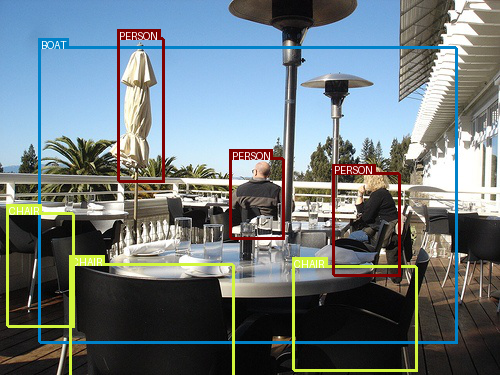

In [19]:
# sample detection
img_path = 'data/VOC/test/JPEGImages/000226.jpg'
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
#detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200).show()
display(detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200))

Ok, so there are some interesting misclassifications here and the model in its current form does not detect the dining table.

Apart from that, as we can see, there is also room for improvement concerning the output here, since, e.g., white letters on light green background is hardly readable. Also, we cannot really visually asses model quality here, since there is no comparison to the ground truth (if available) - so, there is again something to be improved ...

This concludes the material on the SSD method for object detection, but to round things off, there are a few more examples for annotated images. Also, the original tutorial answers some
[FAQs](https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection#faqs) at the end - take a look at those, if you are interested.

### Some more examples

---

<p align="center">
<img src="./img/000029.jpg"/>
</p>

---

<p align="center">
<img src="./img/000045.jpg"/>
</p>

---

<p align="center">
<img src="./img/000062.jpg"/>
</p>

---

<p align="center">
<img src="./img/000075.jpg"/>
</p>

---

<p align="center">
<img src="./img/000085.jpg"/>
</p>

---

<p align="center">
<img src="./img/000092.jpg"/>
</p>

---

<p align="center">
<img src="./img/000100.jpg"/>
</p>

---

<p align="center">
<img src="./img/000124.jpg"/>
</p>

---

<p align="center">
<img src="./img/000127.jpg"/>
</p>

---

<p align="center">
<img src="./img/000128.jpg"/>
</p>

---

<p align="center">
<img src="./img/000145.jpg"/>
</p>

---

## Learning Outcomes

The contents presented here and in the [theory notebook](07a_Intro_OD_Theory.ipynb) were mostly geared towards getting a deeper understanding of the network architecture for Single Shot Object detection and the way to implement it using PyTorch. Having worked through this notebook, you should now

* know the ideas behind the SSD method, in particular
  * multisclae feature maps,
  * Jaccard overlap, aka Intersection over Union
  * priors and multibox regression,
  * hard negative mining,
  * non-maximum suppression;
* be able to augment a base network with auxiliary and prediction convolutions;
* be able to compute the mean average precision metric for object detection;
* know how to annotate images with bounding boxes for detected objects and display these.

---